[[ 0.87626286  0.86374054]
 [ 1.82828584  4.4579437 ]
 [ 2.01347746  3.57015458]
 [ 1.23981316  2.45343409]
 [ 0.48472704  0.2946218 ]
 [ 1.51891495  3.56882513]
 [ 1.64099085  4.30335956]
 [ 0.88039822  1.22965175]
 [ 1.19346358  3.06885503]
 [ 1.26472986  2.78069711]
 [ 0.822557    1.30477095]
 [ 1.63832131  0.89055933]
 [ 0.89966762  0.63268981]
 [ 2.27689262  4.5703536 ]
 [ 1.43297557 -0.30490732]
 [ 2.1514628   2.50282374]
 [ 1.9610083   2.89858122]
 [ 2.43606443  4.64083367]
 [ 2.62294596  3.95724904]
 [ 2.13149577  4.38953667]]


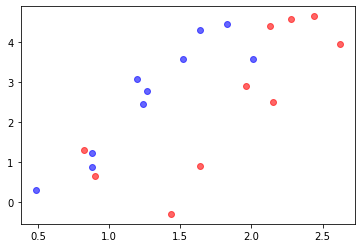

(20, 2)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#np.random.seed(4)
np.random.seed(5)
X = []
X.extend([[1.0 + np.random.normal(0, 0.3), np.random.uniform(0, 10)] for _ in range(10)])
X.extend([[2 + np.random.normal(0, 0.8), np.random.uniform(0, 10)] for _ in range(10)])
W = [[0.5, -0.15], [0.15, 0.5]]
X = np.array(X).dot(np.array(W))
print(X)
import numpy as np
X=np.array(X)

W = ["man", "he", 'brother', 'male', 'dad', 
	'mom', 'female', 'woman', 'she', 'sister']
plt.scatter(X[:len(X)//2,0], X[:len(X)//2,1], alpha=0.6,c='b')
plt.scatter(X[len(X)//2:,0], X[len(X)//2:,1], alpha=0.6,c='r')
#plt.axis([-10,10, -10,10])#
plt.show()
X.shape

In [ ]:
import tqdm

class DensRay:
    def __init__(self, Lemb, Remb):
        self.lemb = Lemb
        self.remb = Remb

    def fit(self, weights=None, normalize_D=True):
        """Fit DensRay
        Args:
            weights: only for binary model; how to weight the two
                summands; if none
                
                
                : apply dynamic weighting. Example input: [1.0, 1.0]
            normalize_D: bool whether to normalize the difference vectors with l2 norm
        """
        #self.computeA_binary_part1(normalize_D=normalize_D)
        self.A_equal = self.opsum(self.lemb) + self.opsum(self.remb)
        self.A_unequal = self.opsum(self.lemb, self.remb) + self.opsum(self.remb, self.lemb)
        self.computeA_binary_part2(weights=weights)
        self.compute_trafo()
        #self.compute_mean_var()

    @staticmethod
    def opsum(a, b=None):
        if b is None: b = a
        out = -torch.ger(a.sum(dim=0), b.sum(dim=0))
        out = out + out.T
        out += b.shape[0] * torch.mm(a.T,a)
        out += a.shape[0] * torch.mm(b.T,b)
        return out

    @staticmethod
    def outer_product_sub_binary(v, M, normD):
        """Helper function to compute the sum of outer products

        While it is not very readable, it is more efficient than
        a brute force implementation.
        """
        d = v.unsqueeze(0) - M
        if normD:
            norm = d.norm(dim=1)
            norm[norm == 0] = 1
            d = d / (norm.unsqueeze(0).T)
        return torch.mm(d.T, d)
    
    def computeA_binary_part1(self, normalize_D=True):
        """First part of computing the matrix A.
        Args:
            normalize_D: bool whether to normalize the difference vectors with l2 norm.
        """
        dim = self.lemb.shape[1]
        self.A_equal = torch.zeros((dim, dim))
        self.A_unequal = torch.zeros((dim, dim))
        for ipos in tqdm.trange(self.lemb.shape[0]):
            v = self.lemb[ipos]
            self.A_equal += self.outer_product_sub_binary(v, self.lemb, normalize_D)
            self.A_unequal += self.outer_product_sub_binary(v, self.remb, normalize_D)
        for ineg in tqdm.trange(self.remb.shape[0]):
            v = self.remb[ineg]
            self.A_equal += self.outer_product_sub_binary(v, self.remb, normalize_D)
            self.A_unequal += self.outer_product_sub_binary(v, self.lemb, normalize_D)

    def computeA_binary_part2(self, weights=None):
        """Second part of computing the matrix A.
        Args:
            weights: only for binary model; how to weight the two 
                summands; if none: apply dynamic weighting. Example input: [1.0, 1.0]
        """
        if weights is None:
            weights = [1 / (2 * self.lemb.shape[0] * self.remb.shape[0]), 1 /
                       (self.lemb.shape[0]**2 + self.remb.shape[0]**2)]
        # normalize matrices for numerical reasons
        # note that this does not change the eigenvectors
        n1 = self.A_unequal.max()
        n2 = self.A_equal.max()
        weights = [weights[0] / max(n1, n2), weights[1] / max(n1, n2)]
        self.A = weights[0] * self.A_unequal - weights[1] * self.A_equal

    def compute_trafo(self):
        """Given A, this function computes the actual Transformation.
        It essentially just does an eigenvector decomposition.
        """
        eigvals, eigvecs = self.A.symeig(eigenvectors=True)
        # need to sort the eigenvalues
        idx = eigvals.argsort(descending=True)
        eigvals, self.eigvecs = eigvals[idx], eigvecs[:, idx]
    
    def compute_mean_var(self):
        first_dim = torch.mm(torch.cat((self.lemb, self.remb)), self.eigvecs)[:, 0]
        self.mean = first_dim.mean()
        self.std = first_dim.var().sqrt()

In [ ]:
import torch

#densray=DensRay(torch.Tensor(X[:len(X)//2]),torch.Tensor(X[len(X)//2:]))
densray=DensRay(torch.Tensor(X[:len(X)//2]),torch.Tensor(X[len(X)//2:]))
densray.fit(normalize_D=False)

In [ ]:
print(densray.eigvecs)
#T = torch.Tensor([[1, 0],[0, 1]])
# 
#T = densray.eigvecs

newX=torch.mm(torch.Tensor(X),densray.eigvecs)
rotatedX=newX
newX[:,0] = 0
newX = torch.mm(newX,densray.eigvecs.t())

tensor([[-0.9798, -0.2000],
        [ 0.2000, -0.9798]])


In [ ]:
densray.opsum(densray.lemb)+densray.opsum(densray.remb) #A_equal

tensor([[109.3994, 279.4760],
        [279.4760, 975.0343]])

In [ ]:
180*(np.cov(densray.lemb.T)+np.cov(densray.remb.T))#A_equal

array([[109.39949306, 279.47599459],
       [279.47599459, 975.03408735]])

In [423]:
2*densray.opsum(densray.lemb,densray.remb) #A_unequal

tensor([[168.4199, 267.4294],
        [267.4294, 977.4932]])

In [425]:
#A_unequal
(180*np.cov(cat.T)[2:,:2]+180*np.cov(cat.T)[:2,2:]+20*(torch.mm(densray.lemb.T,densray.lemb)-torch.mm(densray.lemb.T,densray.remb)+torch.mm(densray.remb.T,densray.remb)-torch.mm(densray.remb.T,densray.lemb)).numpy())

array([[168.41987634, 267.42928654],
       [267.42928654, 977.49306523]])

In [426]:
-torch.mm(densray.lemb.T,densray.remb)

tensor([[-23.5018, -32.4823],
        [-50.3235, -69.9417]])

In [427]:
-torch.mm(densray.remb.T,densray.lemb)

tensor([[-23.5018, -50.3235],
        [-32.4823, -69.9417]])

In [ ]:
cat = torch.cat((densray.lemb, densray.remb),1)

In [ ]:
np.cov(cat.T)

array([[ 0.22094362,  0.6236492 , -0.03058823, -0.05496958],
       [ 0.6236492 ,  2.07549197,  0.16291921,  0.24227166],
       [-0.03058823,  0.16291921,  0.38683134,  0.92899522],
       [-0.05496958,  0.24227166,  0.92899522,  3.34136407]])

In [ ]:
np.cov(cat.T)[2:,:2] + np.cov(cat.T)[:2,2:]
np.cov(cat.T)[2:,:2] + np.cov(cat.T)[:2,2:]

np.cov(cat.T)[2:,:2] + np.cov(cat.T)[:2,2:]



array([[-0.06117647,  0.10794964],
       [ 0.10794964,  0.48454331]])

In [ ]:
10*(torch.mm(densray.lemb.T,densray.lemb)-torch.mm(densray.lemb.T,densray.remb)+torch.mm(densray.remb.T,densray.remb)-torch.mm(densray.remb.T,densray.lemb))

tensor([[ 89.7158, 123.9992],
        [123.9992, 445.1376]])

In [ ]:
10*(torch.mm(densray.lemb.T,densray.lemb)-torch.mm(densray.lemb.T,densray.remb)+torch.mm(densray.remb.T,densray.remb)-torch.mm(densray.remb.T,densray.lemb)).numpy()

array([[ 89.71582 , 123.999176],
       [123.999176, 445.13763 ]], dtype=float32)

In [ ]:
oab/(90*np.cov(cat.T)[2:,:2]+90*np.cov(cat.T)[:2,2:]+10*(torch.mm(densray.lemb.T,densray.lemb)-torch.mm(densray.lemb.T,densray.remb)+torch.mm(densray.remb.T,densray.remb)-torch.mm(densray.remb.T,densray.lemb)).numpy())

tensor([[1.0000, 1.0000],
        [1.0000, 1.0000]], dtype=torch.float64)

In [ ]:
np.cov(densray.lemb.T)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
#pca.fit(X)
x_std = StandardScaler().fit_transform(X)
pca.fit_transform(x_std)
# need to transpose, matrix (n_components, n_features)
T = torch.Tensor(pca.components_)#inverse trasnform matrix
print(T)
#pc1 = np.array(pca.components_)
print(pca.explained_variance_)


tensor([[-0.7071, -0.7071],
        [ 0.7071, -0.7071]])
[1.8342752  0.27098796]


In [ ]:
def train_Conceptor(x, alpha = 1):
    print("starting...")
    #x = orig_embd.vectors
    print(x.shape)
    #Calculate the correlation matrix
    R = x.T.dot(x)/(x.shape[0])
    #Calculate the conceptor matrix
    C = R @ (np.linalg.inv(R + alpha ** (-2) * np.eye(x.shape[1])))
    print("C calculated")
    dim = C.shape[0]
    not_C = np.eye(dim) - C
    return not_C

def process_cn_matrix(subspace, alpha = 2):
    """Returns the conceptor negation matrix
    Arguments
            subspace : n x d matrix of word vectors from a oarticular subspace
            alpha : Tunable parameter
    """
    # Compute the negation conceptor matrix
    negC = train_Conceptor(subspace, alpha)    
    return negC

In [ ]:
#pca = PCA(n_components = 3)
#pca.fit(X)
x_std = StandardScaler().fit_transform(X)
negC = process_cn_matrix(x_std)
# need to transpose, matrix (n_components, n_features)
print(negC*5)
print(np.linalg.inv(negC)/5)
inverse_negc = torch.Tensor(np.linalg.inv(negC))

starting...
(20, 2)
C calculated
[[ 1.54534281 -0.91800958]
 [-0.91800958  1.54534281]]
[[1.         0.59404915]
 [0.59404915 1.        ]]


In [ ]:
from numpy import linalg as la

U,sigma,VT=la.svd(negC)

In [ ]:
U,sigma,VT

(array([[-0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678]]),
 array([0.49267048, 0.12546665]),
 array([[-0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678]]))

In [ ]:
negC*U*VT

array([[ 0.15453428, -0.09180096],
       [-0.09180096,  0.15453428]])

In [ ]:
T, densray.eigvecs,U

(tensor([[-0.7071, -0.7071],
         [ 0.7071, -0.7071]]), tensor([[-0.9798, -0.2000],
         [ 0.2000, -0.9798]]), array([[-0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678]]))

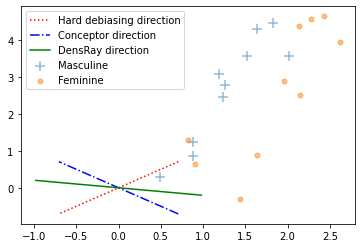

In [ ]:
xaxis = torch.Tensor([[-1,0],[1,0]])
#xaxis = torch.Tensor([[0,-1],[0,1]])
plt.figure()

plt.scatter(X[:len(X)//2,0], X[:len(X)//2,1], alpha=0.5,marker='+',s=100,label='Masculine')
plt.scatter(X[len(X)//2:,0], X[len(X)//2:,1], alpha=0.5,marker='.',s=100,label='Feminine')

plt.plot(torch.mm(xaxis, T)[:,0],torch.mm(xaxis, T)[:,1],'r:',label='Hard debiasing direction')
plt.plot(torch.mm(xaxis, torch.Tensor(VT))[:,0],torch.mm(xaxis, torch.Tensor(VT))[:,1],'b-.',label='Conceptor direction')
plt.plot(torch.mm(xaxis, densray.eigvecs.t())[:,0],torch.mm(xaxis, densray.eigvecs.t())[:,1],'g',label='DensRay direction')
#plt.plot(xaxis[:,0],xaxis[:,1],'g-',label='axis')
plt.legend(loc='best')
plt.savefig('examples.png',dpi=600,format='png',bbox_inches = 'tight')
plt.show()

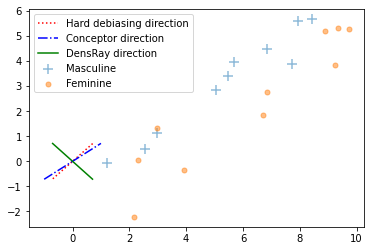

In [ ]:
xaxis = torch.Tensor([[-1,0],[1,0]])
#xaxis = torch.Tensor([[0,-1],[0,1]])
plt.figure()

plt.scatter(X[:len(X)//2,0], X[:len(X)//2,1], alpha=0.5,marker='+',s=100,label='Masculine')
plt.scatter(X[len(X)//2:,0], X[len(X)//2:,1], alpha=0.5,marker='.',s=100,label='Feminine')

plt.plot(torch.mm(xaxis, T)[:,0],torch.mm(xaxis, T)[:,1],'r:',label='Hard debiasing direction')
plt.plot(torch.mm(xaxis, inverse_negc/5)[:,0],torch.mm(xaxis, inverse_negc/5)[:,1],'b-.',label='Conceptor direction')
plt.plot(torch.mm(xaxis, densray.eigvecs.t())[:,0],torch.mm(xaxis, densray.eigvecs.t())[:,1],'g',label='DensRay direction')
#plt.plot(xaxis[:,0],xaxis[:,1],'g-',label='axis')
plt.legend(loc='best')
plt.savefig('examples.png',dpi=600,format='png',bbox_inches = 'tight')
plt.show()

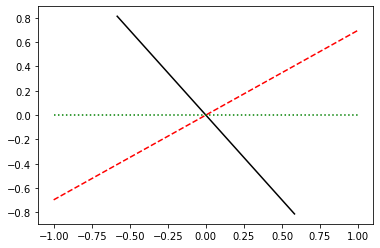

In [ ]:
plt.plot(torch.mm(xaxis, inverse_negc/5)[:,0],torch.mm(xaxis, inverse_negc/5)[:,1],'r--',label='Conceptor direction')
plt.plot(torch.mm(xaxis, densray.eigvecs.t())[:,0],torch.mm(xaxis, densray.eigvecs.t())[:,1],'k-',label='DensRay direction')
plt.plot(xaxis[:,0],xaxis[:,1],'g:',label='axis')